# Question 2
#### Match the APOGEE-red-clump catalog to Gaia DR2, integrate the orbits using galpy for 20 Gyr, and make a density plot in Galactocentric X and Y coordinates of all of the positions of the stars over the next 20 Gyr.

In [1]:
import os
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mp
import gaia_tools.load as load
import gaia_tools.xmatch as xmatch
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util.bovy_conversion import time_in_Gyr

We first use gaia_tools to load the APOGEE red clump catalogue.

In [2]:
apogeerc = load.apogeerc()

C:\ProgramData\Anaconda3\lib\site-packages\gaia_tools-0.2-py3.6.egg\gaia_tools\load\__init__.py:114: UserWarning: Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package
  warnings.warn("Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package")



We will want to store the cross-matched catalogue after generating it, so we will make a folder to hold any data generated by this program.

In [3]:
if not os.path.exists("data"):
    os.mkdir("data")

Now we can perform the cross match with Gaia DR2 using gaia_tools.

In [4]:
if not os.path.exists("data/apogeerc_xmatched.csv"):
    # Cross match APOGEE red clump with Gaia DR2
    xmatched = xmatch.cds(apogeerc, xcat = "vizier:I/345/gaia2", 
                          savefilename = "data/apogeerc_xmatched.csv")[0]
else:
    # Load the cross matched table if already computed
    xmatched = xmatch.cds_load("data/apogeerc_xmatched.csv")

In order to compute orbits for these cross matched stars, we will want to filter out the stars with no radial velocities.

In [5]:
# Filter out stars with no radial velocity
rv_mask = (xmatched['radial_velocity'] != -9999.99)
xmatched_rv = xmatched[rv_mask]

Now separate out each column, and convert parallax to distance.

In [6]:
# Separate the columns of xmatched_rv
ra = xmatched_rv['ra']
dec = xmatched_rv['dec']
d = 1/xmatched_rv['parallax']
pmra = xmatched_rv['pmra']
pmdec = xmatched_rv['pmdec']
rv = xmatched_rv['radial_velocity']

Next, we set the parameters for the orbit integration. We will also be saving the integrated orbit coordinates in a file, so we can start to build a file name that depends on our choice of parameters.

In [7]:
# Choose the number of time steps for the orbit integration
nsteps = 1000
t = np.linspace(0, 20, nsteps)
coord_path = "data/integrated_{}_steps".format(nsteps)

# Choose whether to use astropy physical units, or to convert time
# to Gyr using galpy.util.bovy_conversion
physical = True
if physical:
    t *= u.Gyr
    coord_path += "_physical"
else:
    t /= time_in_Gyr(220., 8.)
    
coord_path += ".npy"

Now we can generate the Orbit objects for each star and integrate over 20 Gyr.

In [8]:
if not os.path.exists(coord_path):
    # Generate and integrate the orbits for each star
    print("Generating orbits...")
    orbits = [Orbit(vxvv = [ra[i], dec[i], d[i], pmra[i], pmdec[i], rv[i]], 
                    ro=8., vo=220., radec=True) for i in range(len(xmatched_rv))]
    
    print("Integrating orbits...")
    for orbit in orbits:
        orbit.integrate(t, MWPotential2014)
    
    # Collect and save the x and y coordinates for each star at each time step
    print("Getting coordinates...")
    x = np.stack([orbit.x(t) for orbit in orbits], axis=1)
    y = np.stack([orbit.y(t) for orbit in orbits], axis=1)
    np.save(coord_path, (x,y))
else:
    # Load the orbit coordinates if already computed
    x, y = np.load(coord_path)

Finally, we plot a 2D histogram of the coordinates over 20 Gyr.

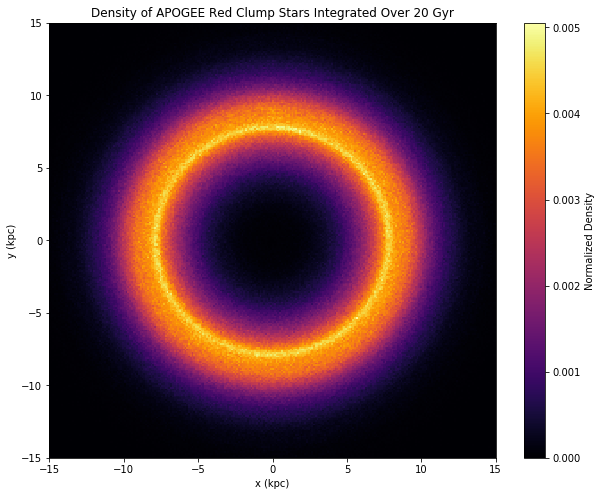

In [9]:
x_coords = x.flatten()
y_coords = y.flatten()
H, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=250, normed=True,
                                   range=((-15, 15),(-15, 15)))
X, Y = np.meshgrid(xedges, yedges)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
colormesh = ax.pcolormesh(X, Y, H, cmap = "inferno")
ax.set_title("Density of APOGEE Red Clump Stars Integrated Over 20 Gyr")
ax.set_xlabel("x (kpc)")
ax.set_ylabel("y (kpc)")
cbar = plt.colorbar(colormesh, label = "Normalized Density")
plt.show()